In [1]:
import os
import sys
import time
import subprocess
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import albumentations
import segmentation_models_pytorch as smp
import timm
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
#location of the saved models
data_dir = '../../xray_image'
model_dir_seg = 'models_GAN_1/'
model_dir_cls = 'models_classification_GAN'
num_workers = 2
image_size = 512
batch_size = 8

In [14]:
submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [15]:
submission.shape

(3582, 12)

In [16]:
class XrayDatasetTest(Dataset):

    def __init__(self, df):

        self.df = df.reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = cv2.imread(os.path.join(data_dir, 'test', row.StudyInstanceUID + '.jpg'))[:, :, ::-1]

        image512 = cv2.resize(image ,(384, 384)).astype(np.float32).transpose(2, 0, 1) / 255.

        return torch.tensor(image512)

In [17]:
dataset_test = XrayDatasetTest(submission)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

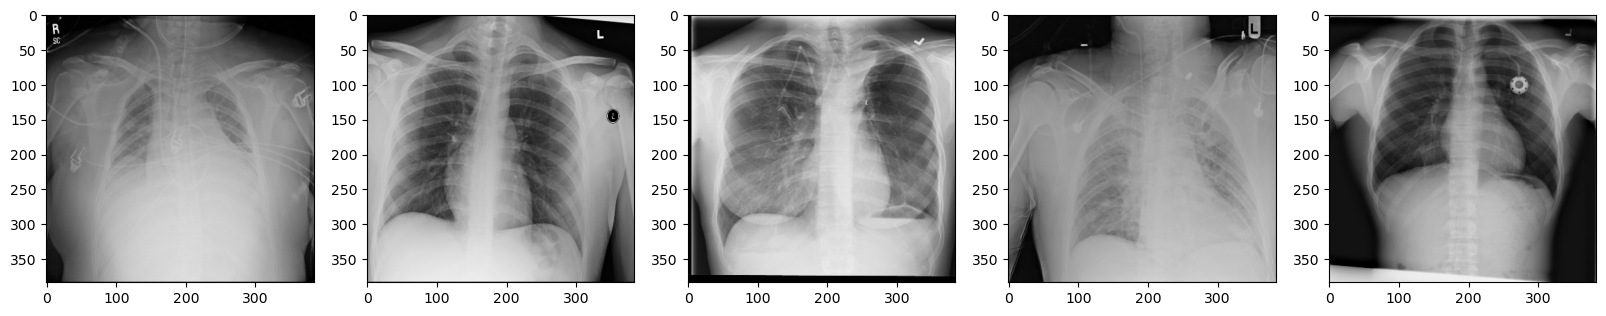

In [18]:
dataset_show = XrayDatasetTest(submission)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

f, axarr = plt.subplots(1,5)

for p in range(5):
    img = dataset_show[p]
    axarr[p].imshow(img.transpose(0, 1).transpose(1,2))

In [19]:
enet_type_seg = 'timm-efficientnet-b5'
kernel_type_seg = 'GAN'

enet_type_cls = 'tf_efficientnet_b5_ns'
kernel_type_cls = 'Classification'

In [23]:
class SegmentationModel(nn.Module):
    def __init__(self, backbone):
        super(SegmentationModel, self).__init__()
        self.seg = smp.UnetPlusPlus(encoder_name=backbone, encoder_weights=None, classes=1, activation=None)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features
    
class EfficientNet(nn.Module):
    def __init__(self, enet_type, out_dim):
        super(EfficientNet, self).__init__()
        self.enet = timm.create_model(enet_type, False)
        self.dropout = nn.Dropout(0.5)
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.repeat(1,4//3+1,1,1)[:, :4])
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x,mask):
        mask = F.interpolate(mask, x.shape[2])
        x = torch.cat([x, mask], 1)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [28]:
model_seg = SegmentationModel(enet_type_seg)
model_seg = model_seg.to(device)
model_seg_file = os.path.join(model_dir_seg, f'generator_best_epoch18.pth')
model_seg.load_state_dict(torch.load(model_seg_file), strict=True)
model_seg.eval()



model_cls = EfficientNet(enet_type_cls,12)
model_cls = model_cls.to(device)
model_cls_file = os.path.join(model_dir_cls, f'classification_best_epoch19.pth')
model_cls.load_state_dict(torch.load(model_cls_file), strict=True)
model_cls.eval()

EfficientNet(
  (enet): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (a

In [29]:
len(test_loader)

448

In [30]:
PROBS = []
with torch.no_grad():
    for batch_id, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        data = data.to(device)
        mask = (model_seg(data).sigmoid()>0.5).float()
        logits = model_cls(data, mask)
        logits[:, :4] = logits[:, :4].softmax(1)
        logits[:, 4:] = logits[:, 4:].sigmoid()
        PROBS.append(logits.cpu())
    
PROBS = torch.cat(PROBS, 0)
PROBS = PROBS[:, [0,1,2,4,5,6,7,8,9,10,11]]
PROBS = PROBS.numpy()

  0%|          | 0/448 [00:00<?, ?it/s]

In [32]:
submission[[
    'ETT - Abnormal',
    'ETT - Borderline',
    'ETT - Normal',
    'NGT - Abnormal',
    'NGT - Borderline',
    'NGT - Incompletely Imaged',
    'NGT - Normal',
    'CVC - Abnormal',
    'CVC - Borderline',
    'CVC - Normal',
    'Swan Ganz Catheter Present'
]] = PROBS



In [33]:
submission.to_csv('submission.csv', index=False)

In [34]:
submission.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,1.967327e-02,3.585190e-01,0.620734,0.000859,0.002902,1.509299e-02,0.965546,0.009753,0.093142,0.957729,9.999352e-01
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,1.526089e-06,2.426763e-06,0.000029,0.000073,0.000077,1.815151e-05,0.000040,0.015624,0.009201,0.969069,7.092128e-05
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,1.912188e-05,5.247443e-05,0.000904,0.000186,0.000060,1.626331e-05,0.000047,0.132665,0.365107,0.716412,4.977730e-05
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,6.482845e-03,6.216635e-02,0.295912,0.015247,0.033369,9.611367e-01,0.033849,0.037907,0.118997,0.894332,3.847852e-03
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,7.288898e-07,7.108903e-07,0.000004,0.000012,0.000007,4.574739e-08,0.000009,0.017287,0.060448,0.899066,8.036988e-07


In [21]:
submission.shape

(3582, 12)